<img src="../../img/data_drift_analysis.png" alt="Concept Drift Analysis" style="width: 100%; border-radius: 20px;"/>

## Objective
The objective of this notebook is to perform an initial analysis of the existing data drifts in the bird sightings provided by DDA and Vogelwarte Switzerland. By conducting this analysis, we aim to gain insights into the temporal changes and variations in the bird sighting data. Before delving into a more in-depth analysis, we want to ensure that there are indeed drifts in the data and develop a sense of which features indicate drifts. This initial exploration will provide a foundation for understanding the dynamics of the dataset and help in identifying potential areas of concern related to data drift.

## Scope
To gain an understanding of data drift in the dataset, the master dataset will be examined for temporal drifts using [Evidently AI](https://www.evidentlyai.com/), a widely applied library that provides tools for monitoring data drift and model performance over time. This analysis will involve comparing the distribution of key features over time to detect any significant changes or shifts. By identifying these temporal drifts, we can assess the stability and consistency of the data over different time periods. This will lay the groundwork for further exploration and mitigation of data drift in the dataset, ultimately contributing to the overall data quality and long-lasting model performance.

In [41]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../../')

import json
import pandas as pd
import plotly.express as px

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.metrics import *

from utils.drift import *

import warnings
warnings.simplefilter("ignore")

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 📚 Concept Drift: A primer </p>

Concept drift refers to the phenomenon where the statistical properties of the target variable (in our case: plausible or not plausible), or the relationships between the input variables and the target variable, change over time. This can have a significant impact on the performance of predictive models, as they may become outdated and less accurate as the underlying data distribution shifts.

## Understanding Concept Drift
Concept drift can occur in various domains, such as financial markets, weather forecasting, healthcare, and online advertising. In financial markets, for example, the relationships between different economic indicators and stock prices may change over time due to changes in market conditions or regulatory policies. In healthcare, the effectiveness of a particular treatment may change as new medications or therapies are developed.

Concept drift may also significantly impact our Ornitho models that estimate the plausibility of bird sightings based on historical data. We use historical sightings estimate the plausibility of certain bird species being present in specific locations. However, concept drift can occur as the distribution and behavior of bird species change over time due to various ecological factors.

For example, climate change can alter the migratory patterns of bird species, leading to shifts in their geographical distribution. Habitat loss and human activities can also impact the presence and abundance of bird species in certain areas. As it is a citizen science project, user bias can also contribute to concept drift if the composition of volunteers changes or as their behaviors and biases evolve. All of these possible changes can result in concept drift, affecting the relationships between environmental variables and the plausibility of bird sightings.

## Impact on modeling
The impact of concept drift on modeling can be significant. Traditional machine learning models are trained on historical data and assume that the underlying data distribution remains constant over time. However, when concept drift occurs, these models may become less accurate and reliable. The predictive power of these models may diminish, leading to inaccuracies in assessing the likelihood of bird species being present in specific locations based on historical data. Understanding and addressing concept drift is essential for maintaining the reliability and effectiveness of models that estimate the plausibility of bird sightings, particularly in the context of ecological citizen science.

## Approaches to address Concept Drift
There are several approaches to address concept drift in modeling. One approach is to continuously monitor the performance of the model and retrain it with new data as concept drift is detected. Another approach is to use adaptive learning algorithms that can automatically adjust the model parameters in response to concept drift. Additionally, ensemble methods, such as bagging and boosting, can be used to combine multiple models trained on different time periods to account for concept drift.

## Objective of this notebook
The motivation behind this notebook is to initially assess the presence and severity of data drift in our data. In later research, we plan on developing mechanisms to mitigate the impact of concept drift on model performance and to gain a deep understanding of the drifts in the data. This approach will enable the development of robust and adaptive predictive models in the context of ecological citizen science, ensuring their reliability and relevance in the face of dynamic and evolving data.

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following file is required:
- Master dataset reduced to 27 species and enriched with EEA grids and land cover information: *[selected_species_50km_luse.csv](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e)*

In [7]:
path_data = '../../../01_Data/datasets/selected_species_50km_luse.csv'

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣ Load data </p>

In this notebook, we analyze Data Drifts based on sightings from 2018-2022 for the 27 species of interest. We will keep all features that were used in our Outlier Detection modeling, therefore we will drop the following unused features:
- `id_species` (as it is also given in `name_species`)
- `id_sighting`
- `timing`
- `precision`
- `total_count`
- `atlas_code`
- `id_observer`

In [32]:
data = pd.read_csv(path_data, index_col=0, low_memory=False).reset_index(drop=True)
display(data.head())
data = data[['name_species', 'date', 'coord_lat', 'coord_lon',  'altitude', 'eea_grid_id', 'LUSE']]
data = data.rename(columns={'LUSE': 'land_cover'})

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id,Numerical_LUSE,LUSE
0,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,-1.051010,0.0,0,37718.0,de,50kmE4200N3300,6,Water
1,29654244,397.0,Schwarzkehlchen,2018-01-01,NaN,53.127639,8.957263,square,0.760781,2.0,0,37803.0,de,50kmE4250N3300,3,Agriculture
2,29654521,463.0,Wiesenpieper,2018-01-01,NaN,50.850941,12.146953,place,270.831300,2.0,0,39627.0,de,50kmE4450N3050,1,Urban
3,29666414,8.0,Haubentaucher,2018-01-01,NaN,51.076006,11.038316,place,158.941010,8.0,0,38301.0,de,50kmE4350N3100,6,Water
4,29656211,8.0,Haubentaucher,2018-01-01,NaN,51.389380,7.067282,place,52.362160,10.0,0,108167.0,de,50kmE4100N3100,1,Urban


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Species and Features affected by data drift </p>
In this chapter, the drift is analyzed for each feature to gain an overall understanding of which bird species and features are particularly affected by data drift, and to what extent. 

To assess the data drift over the entire period, we first compare the data from 2018 with that of 2022. This allows us to observe and quantify the extent of drift that has occurred over the 5-year span.

For this, Evidently requires two frames which are then assessed on data drift. In this notebook, we set all bird sightings of 2022 as our current dataframe, that we want to compare with all bird sightings from 2018, which is called the reference dataframe:

In [33]:
reference = data[data.date.str.contains('2018')]
reference['date'] = pd.to_datetime(reference.date).dt.dayofyear

current = data[data.date.str.contains('2022')]
current['date'] = pd.to_datetime(current.date).dt.dayofyear

analyzed_features = ['date', 'coord_lat', 'coord_lon', 'eea_grid_id', 'altitude', 'land_cover']

Evidently then performs Data Drift Analysis by following these steps:
1. Data Alignment:
Evidently aligns both frames on date, ensuring that the corresponding data points from both time periods are matched for comparison. 

2. Per-feature Drift Calculation:
Using the `DataDriftPreset` as the chosen metrics, evidently calculates various statistical measures and metrics to assess data drift between the reference and current frames. The calculation differ between numerical and categorical features:
    - **Numerical Features:** Evidently utilizes *normed Wasserstein distance* for measuring data drift in our numerical features `date`, `coord_lat`, `coord_lon`, and `altitude`. The *normed Wasserstein distance* is a measure of the difference between two probability distributions, commonly used for numerical features. It quantifies the minimum amount of work (or "distance") required to transform one distribution into the other. In the context of data drift, normed Wasserstein distance provides a metric for assessing the divergence between the distributions of numerical features in different datasets, indicating the extent of drift. 
    - **Categorical Features:** For the categorical features `eea_grid_id` and `land_cover`, *Jensen-Shannon distance* can be applied as a measure of similarity between two probability distributions. It combines the Kullback-Leibler divergence and symmetric properties to measure the difference between distributions.

3. Report Generation:
Based on the calculated metrics, the library compiles a comprehensive report that summarizes the data drift findings. The report provides insights into the specific features that have exhibited drift and the extent of the drift observed between the reference and current frames. In this notebook, we export this report to json-Format to extract only the magnitudes of the feature drifts, also referred to as the *drift score*. In a following notebook, a report for the pygmy owl will be visualized (see `04_drift_analysis/02_pygmy_owl_habitat_drift.ipynb`).


### Results
Initially, the table provides an overview of the features that have exhibited drift over the 5-year duration. A feature is identified as having drifted if its drift score, surpassing a predefined threshold of 0.1, indicates significant divergence. Subsequently, the second visualization employs a heatmap to depict the drift scores, offering a more comprehensive representation of the observed drift severities. From these visualizations, we derive the following insights:
#### 1. Species Analysis
The analysis conducted on the dataset from the years 2018 to 2022 revealed that 18 of the 27 bird species studied exhibited significant data drift. In contrast, the remaining 9 species did not demonstrate substantial changes in the observed features. This finding suggests that approximately two thirds of the species in this study have undergone alterations that could influence their behavioral patterns, geographical distribution, and overall population dynamics.

As visible in the heatmap, particularly high drift scores are recorded for the species Rock Ptarmigan (Alpenschneehuhn), Mountain Bunting (Berghänfling), Western Bonelli's Warbler (Gelbspötter), Bearded Vulture (Gänsegeier), Fire-fronted Serin (Karmingimpel), Eurasian Pygmy Owl (Sperlingskauz), and Citril Finch (Zitronenzeisig). These species exhibit elevated drift values in multiple features when comparing 2022 to 2018 and in comparison to other bird species.

#### 2. Feature Analysis
A detailed examination of the individual features indicates the presence of data drift across all measured variables. However, the extent of drift varied among these features:

- **Date and Location**: The most pronounced drift was observed in features related to date and location. The data suggests that temporal variables and spatial distribution are subject to considerable flux, likely reflecting the dynamic nature of migration patterns and habitat changes.
- **EEA Grid ID**: Data drift was consistently noted across all species concerning the European Environment Agency (EEA) grid ID. This outcome was anticipated, as the grid ID classification does not reflect the relative geographic proximity between grids, thereby providing a less nuanced measure of habitat changes.

- **Land Cover and Altitude**: Changes in land cover and altitude were identified less frequently. Birds typically exhibit strong preferences for particular habitats and elevations, making it uncommon for shifts between distinct habitat types (e.g., from lakeside to forested areas). Consequently, movements are more likely to occur within the same type of land cover, leading to drift in geographic coordinates (latitude and longitude) rather than in land cover classification or altitude.

### Discussion
These initial results indicate that the majority of the bird species analyzed are subject to data drift. The heterogeneity observed in the degree of drift among different features and species highlights the necessity for precise monitoring and the development of adaptive models. Such measures are essential to counteract the potential adverse effects on the predictive accuracy of models over time.

In [39]:
drift_results = calculate_species_drift(data, reference, current, analyzed_features, categorical=True)
create_drift_table(drift_results)

,species_name,date,coord_lat,coord_lon,eea_grid_id,altitude,land_cover
0,Haubentaucher,-,-,-,✅,-,-
1,Schwarzkehlchen,-,-,-,✅,-,-
2,Wiesenpieper,-,-,-,✅,-,-
3,Wasseramsel,-,-,-,✅,-,-
4,Rohrammer,-,✅,-,✅,-,-
5,Mittelspecht,-,-,-,✅,-,-
6,Bergpieper,✅,-,-,✅,-,-
7,Singschwan,-,✅,-,✅,-,-
8,Seeadler,-,-,-,✅,-,-
9,Rostgans,-,✅,✅,✅,-,-


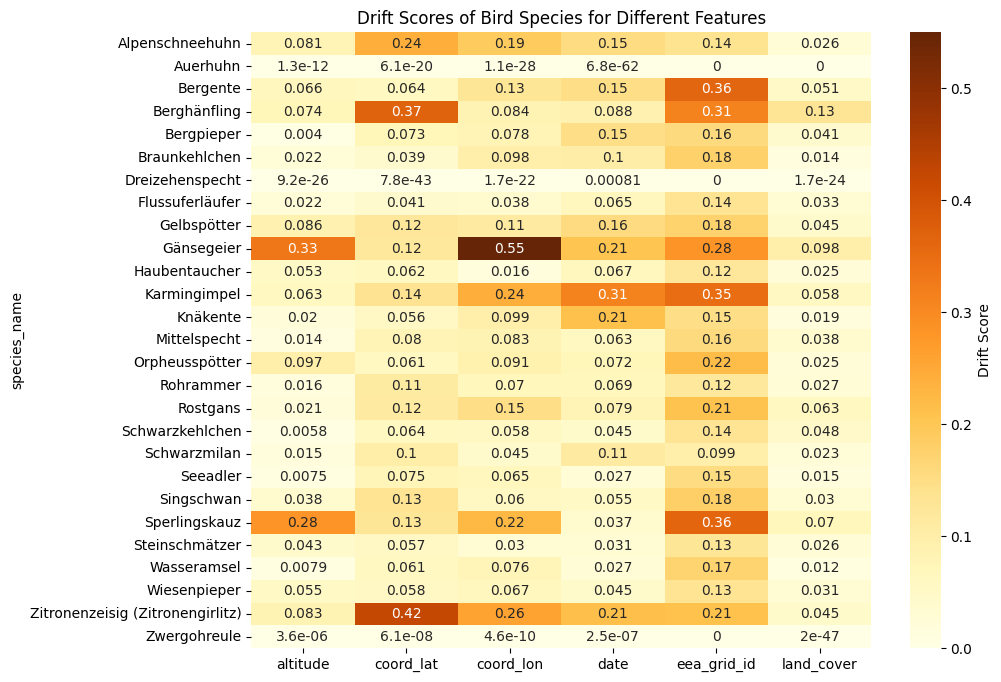

In [42]:
drift_results = calculate_species_drift(data, reference, current, analyzed_features, categorical=False)
create_drift_heatmap(drift_results, analyzed_features)

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Drift behaviour over time </p>

Building upon the initial examination of data drift between the years 2018 and 2022, this chapter delves deeper into the temporal dynamics of data drift. The objective is to discern patterns across the intervening years, determining whether changes in data features are gradual, sudden, recurring, or exhibit random fluctuations.

To investigate the progression of data drift, a year-by-year analysis is conducted, examining the data for each year from 2018 to 2022. This approach allows to capture the nuances of drift behavior over time, rather than solely comparing the start and end points of the period under study, as performed in Chapter 1️⃣ above.

For this, we compare each year with the start year 2018 and assess if and how the drift increases over time.

In [8]:
reference = data[data.date.str.contains('2018')]
reference['date'] = pd.to_datetime(reference.date).dt.dayofyear

years = ['2019', '2020', '2021', '2022']
drift_results = {}
for year in years:
    year_drift_results = {}
    current = data[data.date.str.contains(year)]
    current['date'] = pd.to_datetime(current.date).dt.dayofyear
    for species in data.name_species.unique():
        species_drift = {}
        report = drift_report(reference=reference[reference.name_species == species],
                            current=current[current.name_species == species],
                            analyzed_features=analyzed_features,
                            to_json=True)
        for metric in report['metrics']:
            if metric['metric'] == 'DataDriftTable':
                result = metric['result']
                drift_by_columns = result['drift_by_columns']
                for column_name, column_data in drift_by_columns.items():
                    drift_score = column_data['drift_score']
                    species_drift[column_name] = drift_score
        year_drift_results[species] = species_drift
    drift_results[year] = year_drift_results

In the line plot below, the data drift over time is plotted for each feature and each species. The higher the drift score, the higher the data drift of the given feature and species. Each year is compared to the reference year 2018.

### Results

Based on the visualization below, our findings reveal a complex picture of data drift across different features and species:

- **Gradual Changes:** Certain species demonstrated gradual shifts in specific features. For example, the altitudes of the Griffon Vulture (Gänsegeier) and the Pygmy Owl (Sperlingskauz), as well as the latitudes for the Twite (Berghänfling) showed a steady trend over the years. Similarly, the longitudes of the Citril Finch (Zitronenzeisig) displayed a consistent directional drift.

- **Random Fluctuations**: However, for a lot of species and features, the data did not exhibit a consistent trend but rather fluctuated randomly from year to year. For instance, the Common Rosefinch (Karmingimpel) showed a decrease in drift in the date feature in 2022. Its drift in migration pattern was increasing gradually over four years, and then suddenly decreasing, implying that its migration pattern was very similar to 2018. This unpredictability suggests that multiple factors, possibly including environmental variability and stochastic events, influence the observed features. This shows that a 5-year-window may not be sufficient for a long-term study, as the migration pattern, for example, is highly influenced by the years temperatures, which gradually change over a long period of time (climatic change), but also fluctuate heavily in a shorter time frame of 5 years.

- **Land Cover Stability:** Overall, land cover exhibited the lowest levels of drift across the species studied, aligning with the expectation that habitat preference remains relatively stable over time.

- **Sporadic High Drift:** The Three-toed Woodpecker (Dreizehenspecht) experienced a significant drift in land cover, but this was an isolated event that occurred only in 2019. It may be due to anthropogenic influences or natural disturbances, or user error.

- **Sporadic Altitude Drifts:** As observed in Chapter 1️⃣, altitude is generally not affected by drift. However, some species, such as the Eurasian Pygmy Owl, still exhibit relatively high drift scores for this feature. This can be related to the fact that the Eurasian Pygmy Owl has expanded further north in recent years, where altitudes are lower.

### Discussion
This analysis has revealed that data drift in bird species is not uniformly distributed over time nor consistent across species. The diverse patterns of data drift observed underscore the multifaceted nature of bird dynamics over time. Random fluctuations may indicate the influence of unpredictable environmental factors or the inherent variability in bird behavior. Gradual changes suggest that some species may be responding to consistent environmental pressures or processes.

In [9]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
features = ['date', 'coord_lat', 'coord_lon', 'altitude', 'eea_grid_id', 'land_cover']
species = list(drift_results['2019'].keys())

# Create subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=features)

for i, feature in enumerate(features, start=1):
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1
    
    for species_name in species:
        fig.add_trace(go.Scatter(x=list(drift_results.keys()), 
                                 y=[drift_results[year][species_name][feature] for year in drift_results.keys()], 
                                 mode='lines',
                                 name=species_name),
                      row=row, col=col)

    fig.update_xaxes(title_text='Year', row=row, col=col)
    fig.update_yaxes(title_text='Drift Score', row=row, col=col)

fig.update_layout(title='Drift Scores of Different Features Over Years', height=800, width=1000)
fig.update_xaxes(title_text="Year", row=3, col=1)
fig.update_yaxes(title_text="Drift Score", row=2, col=1)
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                title=dict(x=0.5, y=0.95, font=dict(size=24), text='drifts scores per feature and year', xanchor='center'),
                legend_title_text='species name')
fig.show()

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣ Summary and Discussion</p>

In summary, the initial analysis of data drift in bird sightings from 2018 to 2022 has provided valuable insights into the temporal changes and variations in the dataset. The analysis revealed that approximately two-thirds of the bird species studied exhibited significant data drift, indicating potential changes in their behavioral patterns, geographical distribution, and overall population dynamics. The features related to date and location, such as latitude, longitude, and EEA grid ID, showed the most pronounced drift, reflecting the dynamic nature of migration patterns and habitat changes.

The year-by-year analysis further elucidated the complexity of data drift, with some species and features exhibiting gradual changes over time, while others displayed random fluctuations. The stability of land cover across the species studied was notable, indicating relatively consistent habitat preferences over the years. However, sporadic high drift events and isolated instances of significant drift in certain features were also observed, suggesting the influence of unpredictable environmental factors, anthropogenic influences, or user bias.

The analysis has highlighted the importance of continued monitoring and adaptive modeling to effectively address the diverse patterns of data drift observed in the bird sighting dataset. To maintain high performance of our models that predict the plausibility of the collected bird sighting data, it is crucial to develop strategies that can account for the variability and unpredictability of data drift over time. The changes observed in the data were partly very random, indicating that building model adaptability will not be straightforward. Understanding and addressing these random fluctuation patterns will be essential for developing robust and adaptive modeling techniques.

Furthermore, while the 5-year analysis allowed us to identify short-term drifts and fluctuations, it is evident that to capture long-term gradual shifts, such as those influenced by climate change or habitat alterations, a larger time frame would be necessary. The 5-year span may allow us to find indicators of long-term gradual shifts, but to truly understand and adapt to long-term changes, we need to consider a bigger time frame. However, it is important to note that our models should also be adapted to short-term changes, which we can effectively achieve within the 5-year time frame. This highlights the need for a balanced approach that considers both short-term and long-term data drift patterns in the development of adaptive modeling techniques.

Overall, addressing data drift in bird sightings is crucial for maintaining the accuracy and effectiveness of predictive models, especially in the context of ecological citizen science and biodiversity conservation efforts. By gaining a deeper understanding of data drift and its implications, we can develop strategies to mitigate its impact and ensure the reliability of models in the face of dynamic and evolving data.


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 4️⃣ Outlook</p>


As a next step, we will delve deeper into the drift analysis of the most impactful features, namely date and habitat, to gain a comprehensive understanding of the temporal changes and variations in these critical aspects of the bird sighting dataset. This in-depth analysis will be conducted as a case study focusing on the Eurasian Pygmy Owl (Sperlingskauz), a species that has exhibited notable data drift in these features. By conducting a detailed examination of the drift patterns of date and habitat for the pygmy owl, we aim to uncover insights that can be applied to the broader understanding of data drift in ecological processes.

Building on the insights gained from the case study, we will further formulate and prioritize the actions we intend to pursue in our ongoing research on data drift in bird dynamics. This can involve developing strategies to mitigate the impact of data drift, identifying potential indicators of long-term shifts influenced by ecological factors, and adapting our modeling techniques to account for both short-term fluctuations and long-term trends. By integrating the findings, we aim to develop targeted and effective approaches to address data drift in bird populations, ultimately contributing to the reliability and relevance of our predictive models in the context of ecological citizen science.
